In [1]:
import torch 
import os
import sys
os.chdir('/home/baly/projects/sopt_shape')
from lib.library import *
from lib.lib_ot import *
from lib.sliced_opt import *
from lib.lib_shape import *
from lib.cpd import *
from lib.icp_ffd import *

method is init
init
results/2D_fish_0.00/
(91, 2)
(91, 2)


FileNotFoundError: [Errno 2] No such file or directory: 'results/2D_fish_0.00//pic/init.jpg'

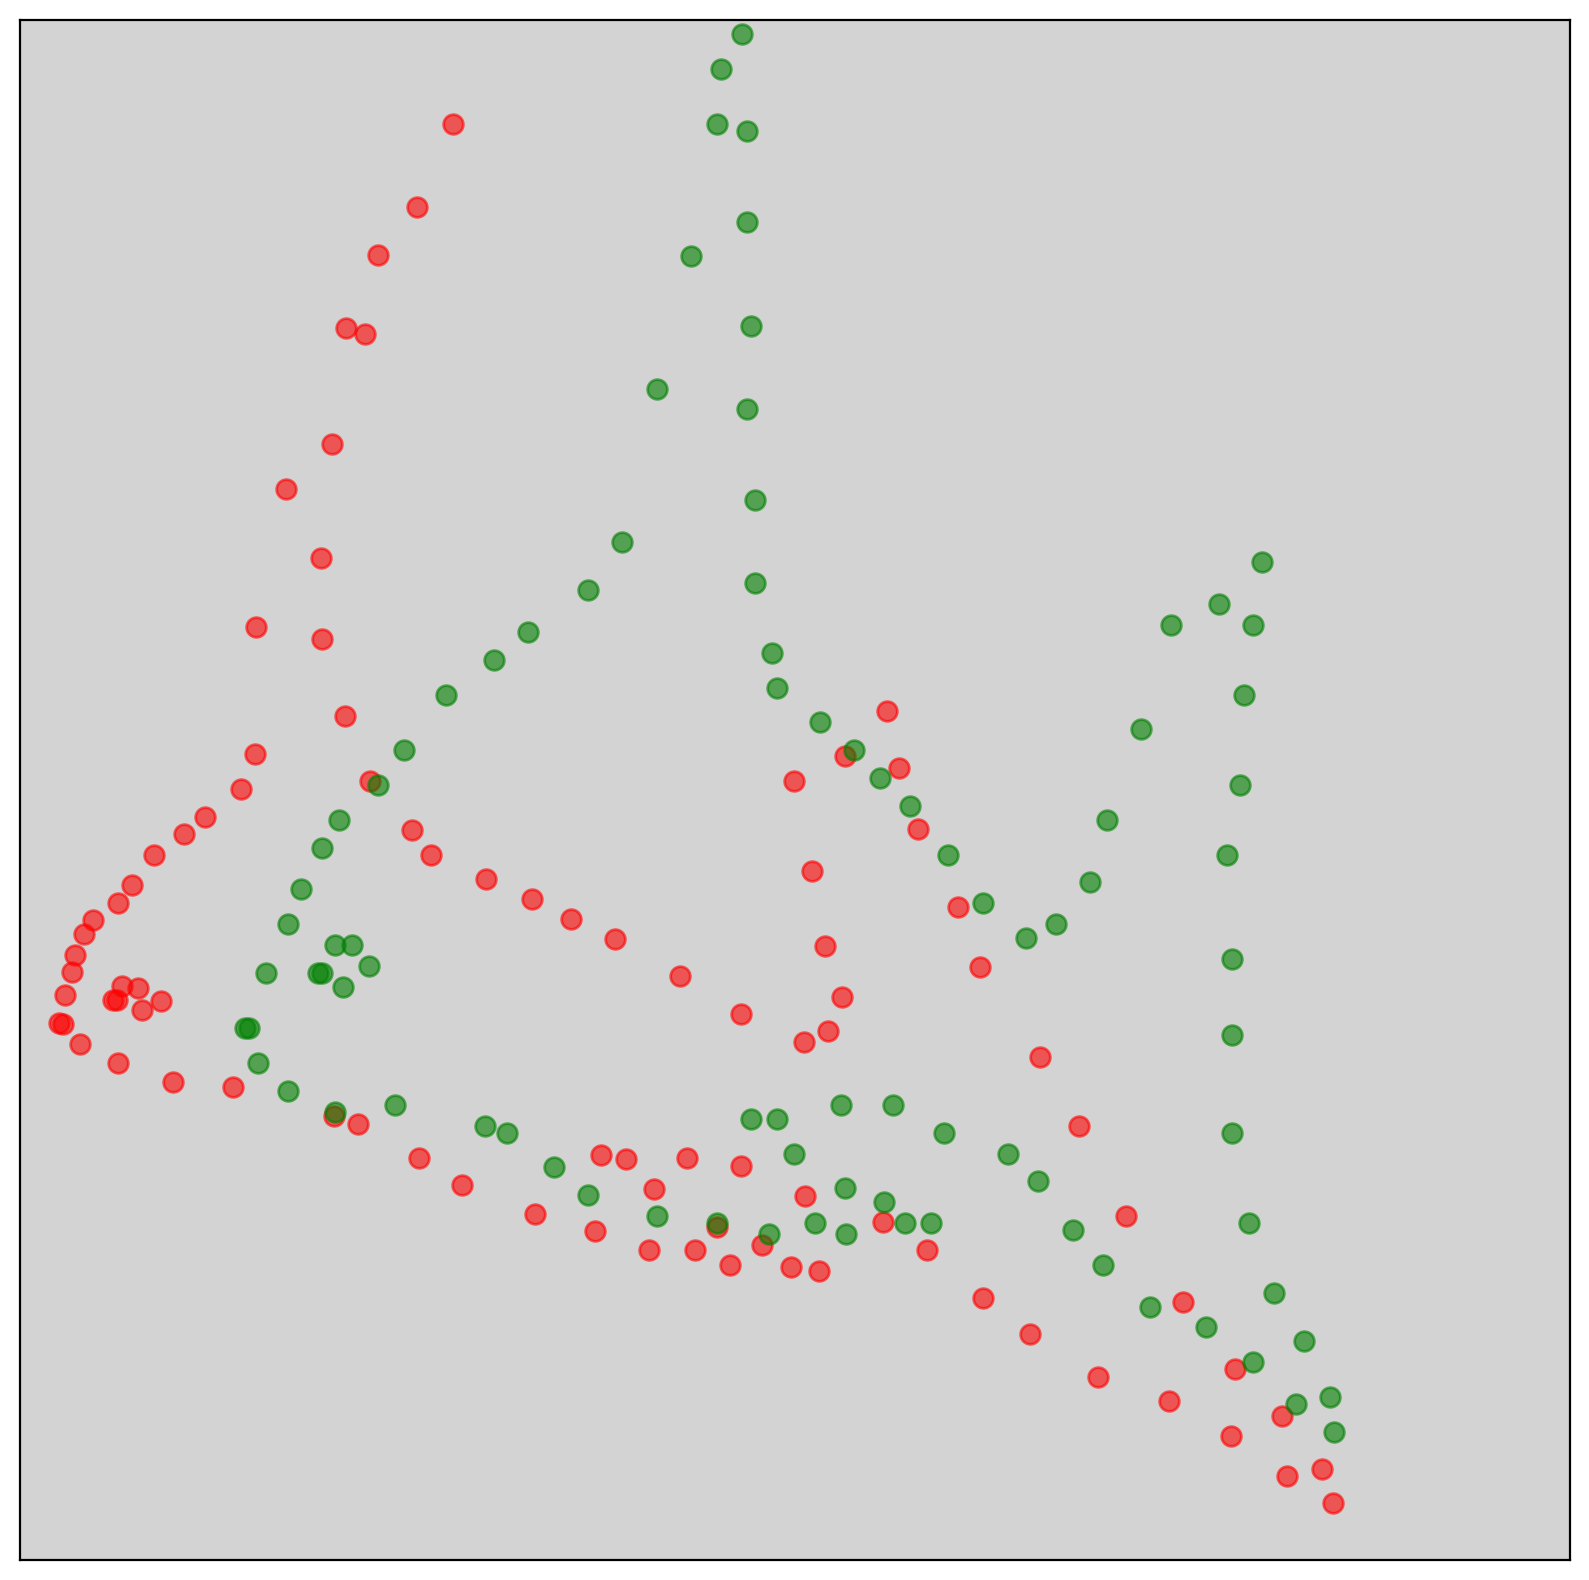

In [2]:
label='2D_fish'
method_list=[
     'init',
'CPD',
'OT-RBF',
'OT-TPS', 
'SOT-RBF',
'SOT-TPS',
'TPS-RPM',
'TPS-RPM-new',
'OPT-RBF',
'OPT-TPS',
'SOPT-RBF',
'SOPT-TPS'
]
eta_list=[0,0.10,0.20,0.30]
for method in method_list:
    print('method is',method)
    for (eta_id,eta) in enumerate(eta_list):
        print(method)
        data=torch.load('data/%s.pt'%(label))
        save_path='results/%s_%0.2f/'%(label,eta)
        print(save_path)
        X0=data['X0']
        N0=X0.shape[0]
        X=data['X'+str(eta)].copy()[0:N0]
        Y=data['Y'+str(eta)].copy()
        print(X.shape)
        print(Y.shape)
        N1=X.shape[0]
        device='cuda:1'
        sigma2,eps=0.05,1.0
        Lambda=2*np.sum((X[0:N0].mean(0)-Y[0:N0].mean(0))**2)
    
        corr_ot={'name':'ot'}
        corr_opt={'name':'opt','N0':N0}
        corr_sot={'name':'sot','n_proj':100}
        corr_sopt={'name':'sopt','n_proj':100,'N0':N0}
        corr_sinkhorn={'name':'sinkhorn','reg':0.1*Y.var(),'Lambda':Lambda}
        corr_sinkhorn_pr={'name':'sinkhorn_pr','reg':0.01*Y.var(),'N0':N0}
        kernel_gaussian={'name':'gaussian','C':X.copy(),'param':sigma2,'eps':1.0}
        kernel_tps={'name':'tps','C':X.copy(),'param':2,'eps':1.0}

        if method == 'init':
            make_plot_fish(X,Y,N0,'%s/pic/%s.jpg'%(save_path,method))
        elif method == 'CPD':
            start_time=time.time()
            model,Yhat_list,record_idx=CPD(X, Y , n_iter_max=100, n_iter_rigid=20)
            end_time=time.time()
        else:
            # choose corr parameters 
            if 'OT' in method and 'SOT' not in method:
                corr=corr_ot
            elif 'SOT' in method:
                corr=corr_sot
            elif 'OPT' in method and 'SOPT' not in method:
                corr=corr_opt
            elif 'SOPT' in method:
                corr=corr_sopt
            elif 'RPM' in method and 'new' not in method:
                corr=corr_sinkhorn
            elif 'RPM-new' in method:
                corr=corr_sinkhorn_pr
            # load the kernel 
            if 'RBF' in method:
                kernel=kernel_gaussian
            elif 'TPS' in method:
                kernel=kernel_tps 
            print('kernel is',kernel['name'])
            print('corr is',corr['name'])
            

            start_time=time.time()
            model,Yhat_list,record_idx=ot_registration(X,Y,N0,kernel=kernel,
                                                              corr=corr,n_iter_max=100,n_iter_rigid=20,
                                                              threshold=0.2,record_idx=None,
                                                       device=device,verbose= False,
                                                      fix_mass=True)
            end_time=time.time()
        if method !='init':
            print('record_idx is',record_idx)
            torch.save((model,Yhat_list,record_idx,end_time-start_time),save_path+'%s.pt'%(method))
            print('time is ',end_time-start_time)
        print('<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<end<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<')

In [3]:
'%s/pic/%s.jpg'%(save_path,method)

'results/2D_fish_0.00//pic/init.jpg'

In [14]:
label='2D_fish'
data=torch.load('data/%s.pt'%(label))

for method in method_list[1:]:
    for eta in eta_list:
        save_path='results/%s_%0.2f/'%(label,eta)
        print(save_path)

        X0=data['X0']
        N0=X0.shape[0]
        permutation=data['permutation%s'%eta]
        X=data['X'+str(eta)].copy()[0:N0]
        Y=data['Y'+str(eta)].copy()

        model,Yhat_list1,record_idx,runing_time=torch.load(save_path+'%s.pt'%(method))
        print('<<<<<<<<<<<<<<<begin<<<<<<<<<<<<<<<<<<<<')      
        print('method is %s, record_idx is %s'%(method,record_idx))
        error_list=compute_error(X=X.copy(),Y=Y.copy(),N0=N0,permutation=permutation,model=model,method=method,plot_func=make_plot_fish)
        torch.save((record_idx,error_list),save_path+'%s_error.pt'%(method))
        
        Yhat_list=model_to_Yhat(model,X,method)
        path=save_path+'pic/'+method
        visual(Yhat_list,Y,N0,path,record_idx,make_plot_fish,log=False)
        print('<<<<<<<end<<<<<<<<<<<<')

results/2D_fish_0.00/


FileNotFoundError: [Errno 2] No such file or directory: 'results/2D_fish_0.00/CPD.pt'

In [7]:
eta_list=[0.00,0.10,0.20,0.30]
label_list=['2D_fish']
for method in method_list[1:]:
    for eta in eta_list:
        print('<<<<<<<<<<<<<<<begin<<<<<<<<<<<<<<<<<<<<')    
        print('eta=%s,method=%s'%(eta,method))
        error=[]
        for label in label_list:
            print('label is',label)
            save_path='results/%s_%0.2f/'%(label,eta)
            record_idx,error_list=torch.load(save_path+'%s_error.pt'%method)
            error.append(error_list[-1])
        error=np.array(error)
        #print(error)
        print('mean of error is %s, standard deviation is %s'%(error.mean(),error.std()))
        print('<<<<<<<<<<<<<<end<<<<<<<<<<<<<<<<<<<<<<<<<<<<<')



<<<<<<<<<<<<<<<begin<<<<<<<<<<<<<<<<<<<<
eta=0.0,method=CPD
label is 2D_fish
mean of error is 0.17120885291217183, standard deviation is 0.0
<<<<<<<<<<<<<<end<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
<<<<<<<<<<<<<<<begin<<<<<<<<<<<<<<<<<<<<
eta=0.1,method=CPD
label is 2D_fish
mean of error is 0.17150197973786815, standard deviation is 0.0
<<<<<<<<<<<<<<end<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
<<<<<<<<<<<<<<<begin<<<<<<<<<<<<<<<<<<<<
eta=0.2,method=CPD
label is 2D_fish
mean of error is 0.17156273938017427, standard deviation is 0.0
<<<<<<<<<<<<<<end<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
<<<<<<<<<<<<<<<begin<<<<<<<<<<<<<<<<<<<<
eta=0.3,method=CPD
label is 2D_fish
mean of error is 0.17837492473537794, standard deviation is 0.0
<<<<<<<<<<<<<<end<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
<<<<<<<<<<<<<<<begin<<<<<<<<<<<<<<<<<<<<
eta=0.0,method=OT-RBF
label is 2D_fish
mean of error is 0.03217886882422501, standard deviation is 0.0
<<<<<<<<<<<<<<end<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
<<<<<<<<<<<<<<<begin<<<<<<<<<<<<<<<<<<<<
eta=0.1,method=O

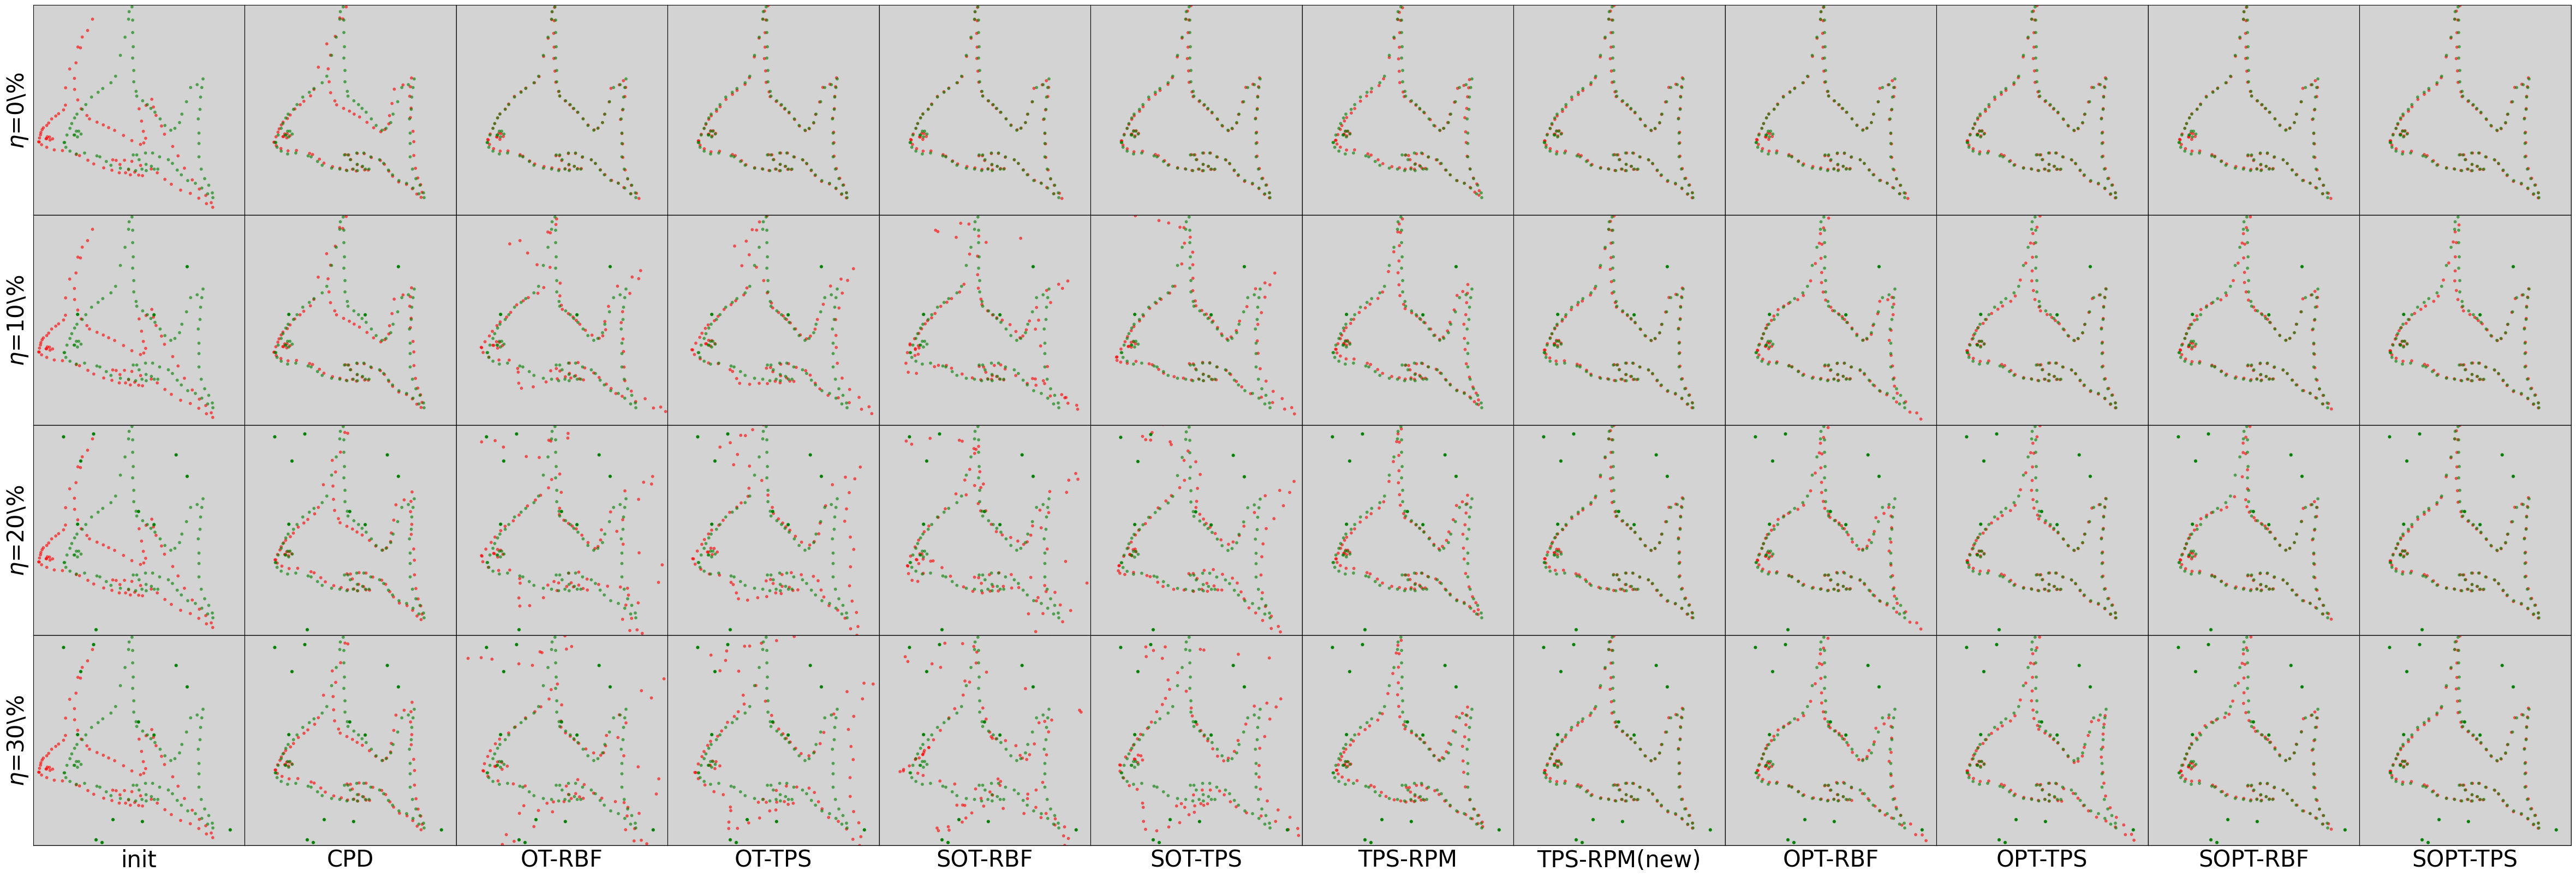

In [18]:
method_list=[
    'init',
  'CPD',
'OT-RBF',
'OT-TPS', 
'SOT-RBF',
'SOT-TPS',
 'TPS-RPM',
 'TPS-RPM-new',
  'OPT-RBF',
  'OPT-TPS',
   'SOPT-RBF',
   'SOPT-TPS'
]


import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# List of PNG file paths.
# Replace this with the paths to your own images.


# Number of rows and columns

eta_list=[0.00,0.10,0.20,0.30]

cols = len(method_list)
rows = len(eta_list)



# Index for iterating over filepaths
index = 0

# Iterate over each subplot and display the image


    
# Create a figure
fig, axs = plt.subplots(rows, cols, figsize=(12*5, 4*5))
# Remove the gaps between subplots
    
for (j,eta) in enumerate(eta_list):
    save_path='results/%s_%0.2f/'%(label,eta)
    for (i,method) in enumerate(method_list):
        # print('method here',method)
        if i in [0]:
            path=save_path+'pic/init.jpg'
        else:
            path=save_path+'pic/'+method+'_final.jpg'
        img = mpimg.imread(path)
        img_crop=img[:,:,:]
        axs[j,i].imshow(img_crop)
        axs[j,i].set_xticks([])
        axs[j,i].set_yticks([])
        # axs[i, j].axis('off')  # Hide axes
        if j==rows-1:
            #print('method here2',method)
            #print('i is',i)
            if method=='TPS-RPM-new':
                method_name='TPS-RPM(new)'
            else:
                method_name=method
            axs[j, i].set_xlabel(method_name,fontsize=30)
        if i==0:
            axs[j, i].set_ylabel('$\eta$=%i'%(eta*100)+'\%',fontsize=30)
        
#     for (i,method) in enumerate(method_list):
#         fig.text(0.1 + (i * 0.1), 0.05, method, ha='center')
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig('results/2d_fish_row.pdf', bbox_inches='tight', pad_inches=0)
# Display the figure
plt.show()

In [16]:
str(int(eta*100))+'\%'

'0\\%'

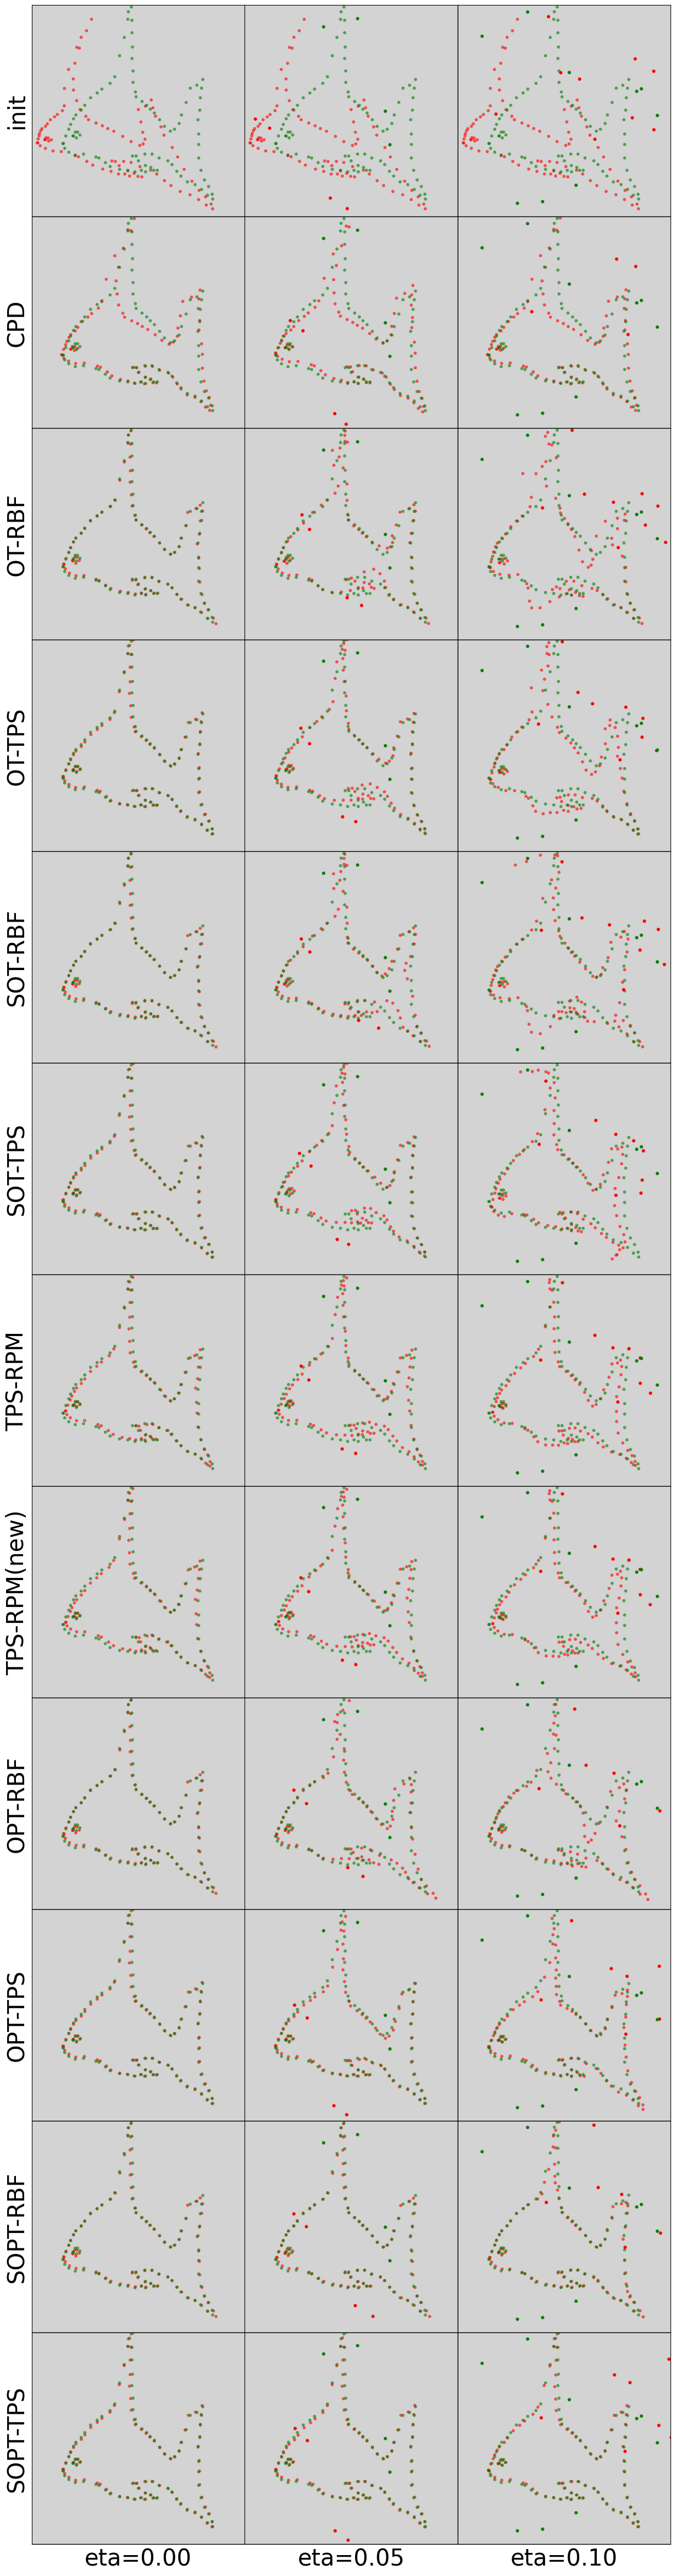

In [6]:
method_list=[
    'init',
  'CPD',
'OT-RBF',
'OT-TPS', 
'SOT-RBF',
'SOT-TPS',
 'TPS-RPM',
 'TPS-RPM-new',
  'OPT-RBF',
  'OPT-TPS',
   'SOPT-RBF',
   'SOPT-TPS'
]
eta_list=[0.00,0.05,0.10]
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# List of PNG file paths.
# Replace this with the paths to your own images.


# Number of rows and columns

rows = len(method_list)
cols = len(eta_list)



# Index for iterating over filepaths
index = 0

# Iterate over each subplot and display the image


    
# Create a figure
fig, axs = plt.subplots(rows, cols, figsize=(3*5, 12*5))
# Remove the gaps between subplots
    
for (j,eta) in enumerate(eta_list):
    save_path='results/%s_%0.2f/'%(label,eta)
    for (i,method) in enumerate(method_list):
        # print('method here',method)
        if i in [0]:
            path=save_path+'pic/init.jpg'
        else:
            path=save_path+'pic/'+method+'_final.jpg'
        img = mpimg.imread(path)
        img_crop=img[:,:,:]
        axs[i, j].imshow(img_crop)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        # axs[i, j].axis('off')  # Hide axes
        if j==0:
            #print('method here2',method)
            #print('i is',i)
            if method=='TPS-RPM-new':
                method_name='TPS-RPM(new)'
            else:
                method_name=method
            axs[i, j].set_ylabel(method_name,fontsize=30)
        if i==rows-1:
            axs[i, j].set_xlabel('eta=%0.2f'%eta,fontsize=30)
        
#     for (i,method) in enumerate(method_list):
#         fig.text(0.1 + (i * 0.1), 0.05, method, ha='center')
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig('results/2D_fish_col.pdf', bbox_inches='tight', pad_inches=0)
# Display the figure
plt.show()

In [ ]:
def recover_rotation(X,Y,rescale=True):
    """
    return the optimal rotation, scalling based on the correspondence (X,Y) 
    
    Parameters:
    ----------
    X: numpy array, shape (n,d), flaot64, target
    Y: numpy array, shape (n,d), flaot64, source
    
    Return:
    --------
    rotation: numpy array, shape (d,d), float64 
    scalling: float64 
    
    """

        
    n,d=X.shape
    X_c=X-vec_mean(X)
    Y_c=Y-vec_mean(Y)
    YX=Y_c.T.dot(X_c)
    U,S,VT=np.linalg.svd(YX)
    R=U.dot(VT)

    diag=np.eye(d,dtype=np.float64)
    diag[d-1,d-1]=np.linalg.det(R.T)
    rotation=U.dot(diag).dot(VT)
    scalling=np.sum(np.abs(S.T))/np.trace(Y_c.T.dot(Y_c))
    print('trace Y_c is',np.trace(Y_c.T.dot(Y_c)))
    return rotation,scalling

def icp_step_gpu(Y,X,rescale=False,device='cpu'):
    """
    return the optimal rotation, scalling based on the correspondence (Target,Source) 
    
    Parameters:
    ----------
    Target: numpSource array, shape (n,d), flaot64, target
    Source: numpy array, shape (n,d), flaot64, source
    
    Return:
    --------
    rotation: numpy array, shape (d,d), float64 
    scalling: float64 
    
    """
    dtype=X.dtype
    Y_tc,X_tc=torch.from_numpy(Y).to(device).to(torch.float32),torch.from_numpy(X).to(device).to(torch.float32)
    n,d=X_tc.shape
    Y_center,X_center=Y_tc-torch.mean(Y_tc,0),X_tc-torch.mean(X_tc,0)
    
    XY=X_center.T.mm(Y_center)

    U,Sigma,VT=torch.linalg.svd(XY)
    UVT=U.mm(VT)
    diag=torch.eye(d,device=device)
    diag[d-1,d-1]=torch.linalg.det(UVT.T)
    R=U.mm(diag).mm(VT)
    S=torch.sum(torch.abs(Sigma.T))/torch.trace(X_center.T.mm(X_center))
    print('torch trace X_c is',torch.trace(X_center.T.mm(X_center)))
    #Y_prime2.mean(0)-Target[Domain].dot(R).mean(0)
    
    if rescale==True:
        beta=torch.mean(Y_tc,0)-torch.mean(X_tc.mm(R),0)*S
    else:
        beta=torch.mean(Y_tc,0)-torch.mean(X_tc.mm(R),0)
    return R.cpu().numpy().astype(dtype),S.cpu().numpy().astype(dtype),beta.cpu().numpy().astype(dtype)

X=np.random.rand(10,3)

Y=2*X+0.6
X_c=X-vec_mean(X)
Y_c=Y-vec_mean(Y)
S3=np.sqrt(np.trace(Y_c.T.dot(Y_c))/np.trace(X_c.T.dot(X_c)))
R1,S1=recover_rotation(Y,X,rescale=False)
R2,S2,beta=icp_step_gpu(Y,X,rescale=False,device='cpu')
print('tace of source outside',np.trace(X_c.T.dot(X_c)))
print(S1-S2)
print(S1-S3)
print(S3)


results/3D_neutral_2_29_0.05/


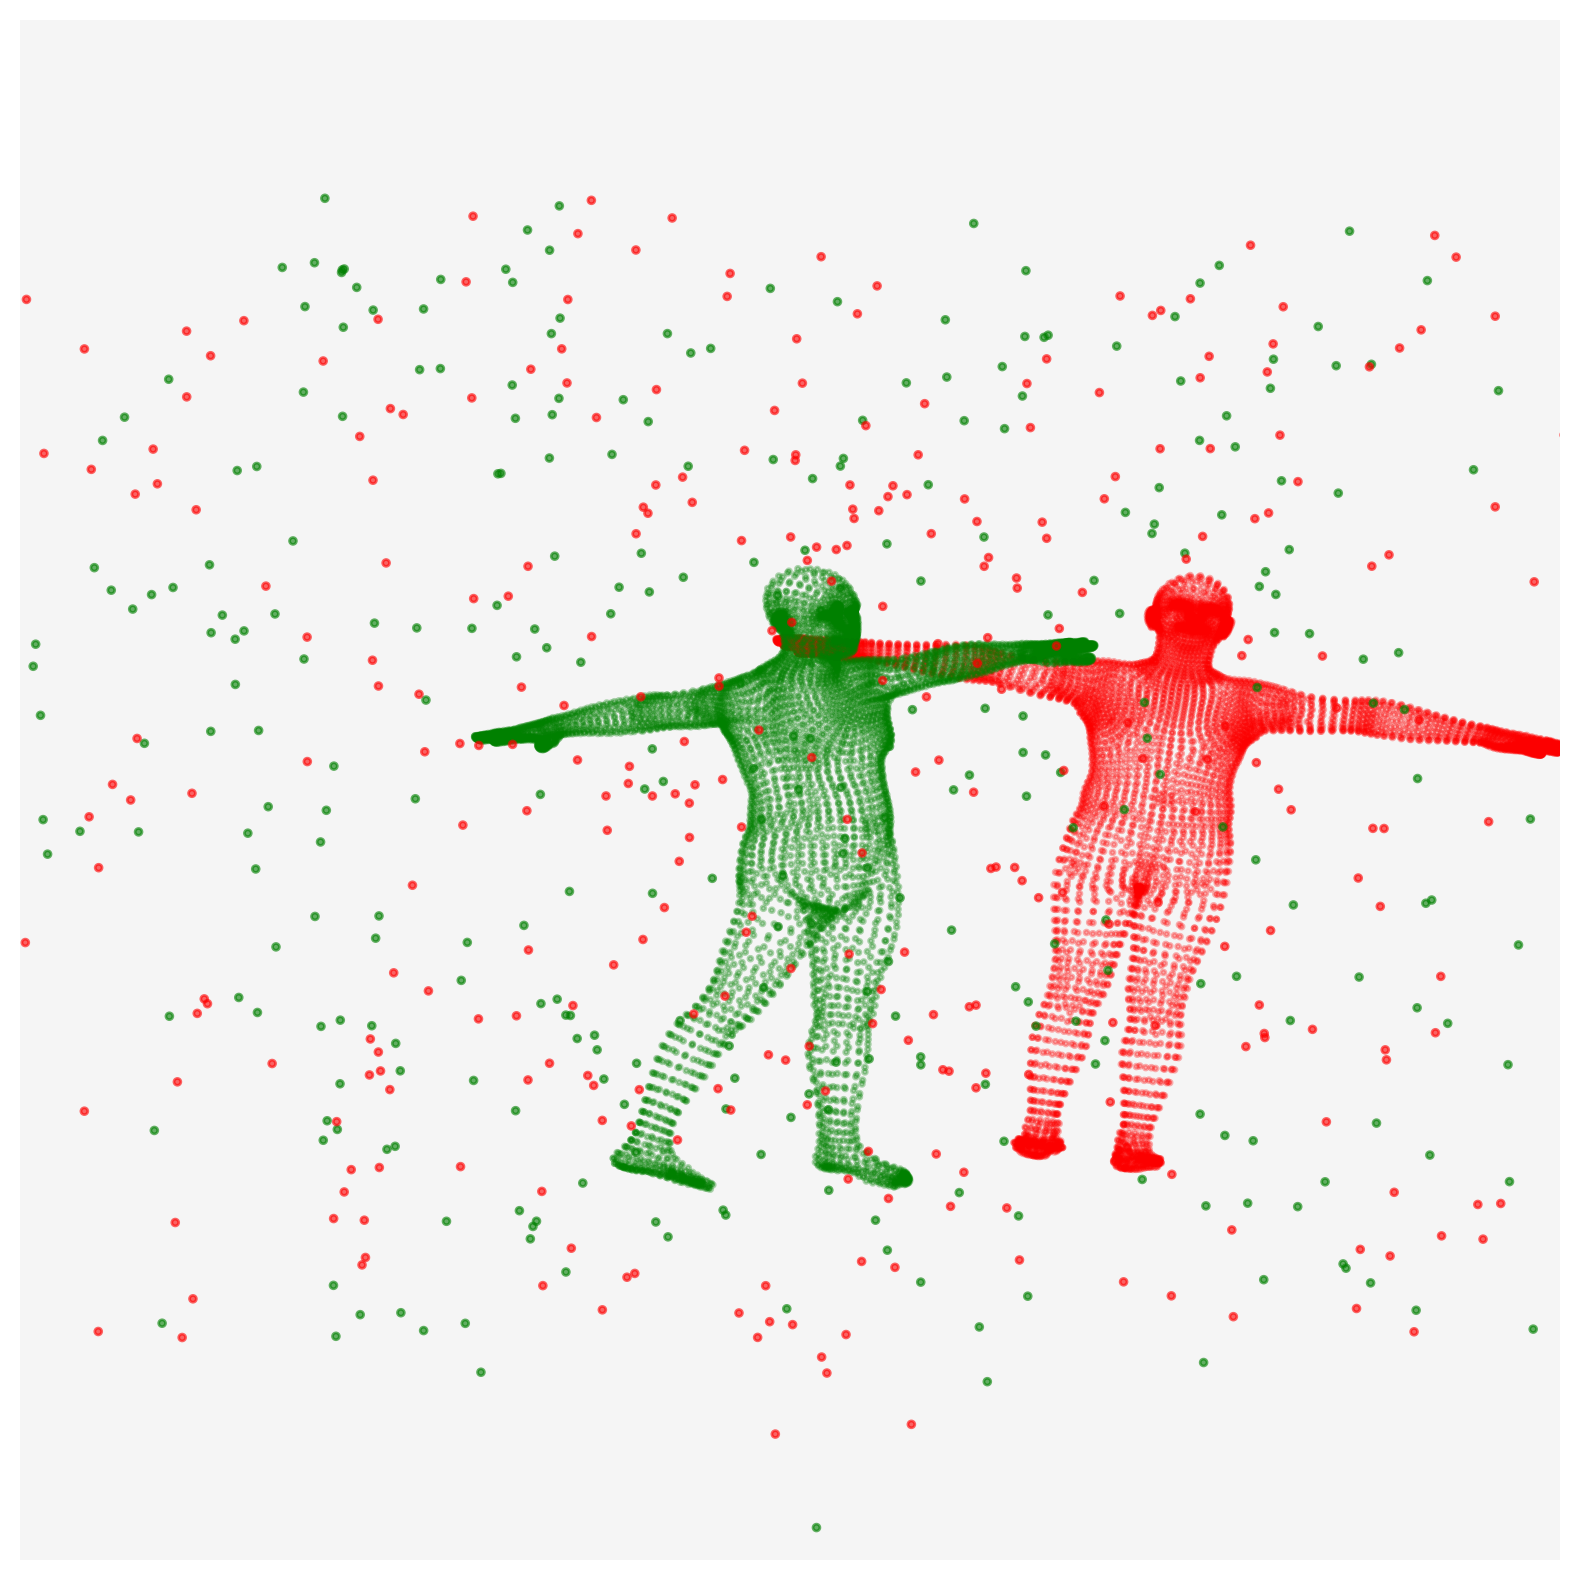

CPD


NameError: name 'record_idx' is not defined

In [2]:
# load data 
label='neutral_2_29'
data=torch.load('data/%s.pt'%(label))
eta_list=[0.05,0.10]
device='cuda:0'

method_list=[
    'init',
   'CPD',
   'OT-RBF',
   'OT-TPS', 
   'SOT-RBF',
   'SOT-TPS',
   'TPS_RPM',
   'TPS_RPM(new)',
   'OPT-RBF',
   'OPT-TPS',
    'SOPT-RBF',
    'SOPT-TPS'
]

for eta in eta_list:
    save_path='results/3D_%s_%0.2f/'%(label,eta)
    print(save_path)
    X0=data['X0']
    N0=X0.shape[0]
    X=data['X'+str(eta)]
    Y=data['Y'+str(eta)]
    make_plot(X,Y,N0)
    device='cuda:0'
    sigma2,eps=0.05,1.0

    Lambda=2*np.sum((X[0:N0].mean(0)-Y[0:N0].mean(0))**2)

    corr_ot={'name':'ot'}
    corr_opt={'name':'opt','N0':N0}
    corr_sot={'name':'sot','n_proj':100}
    corr_sopt={'name':'sopt','N0':N0+20,'n_proj':100}
    corr_sinkhorn={'name':'sinkhorn','reg':0.1*Y.var(),'N0':N0,'Lambda':Lambda}
    corr_sinkhorn_pr={'name':'sinkhorn_pr','reg':0.01*Y.var(),'N0':N0}
    kernel_gaussian={'name':'gaussian','C':X.copy(),'param':sigma2,'eps':1.0}
    kernel_tps={'name':'tps','C':X.copy(),'param':2,'eps':1.0}


    for method in method_list[1:]:
        print(method)
        if method == 'CPD':
            start_time=time.time()
            model_list,Yhat_list,record_index=CPD(X, Y , n_iter_max=100, n_iter_rigid=10)
            end_time=time.time()
        else:
            # choose corr parameters 
            if 'OT' in method and 'SOT' not in method:
                corr=corr_ot
            elif 'SOT' in method:
                corr=corr_sot
            elif 'OPT' in method and 'SOPT' not in method:
                corr=corr_opt
            elif 'SOPT' in method:
                corr=corr_sopt
            elif 'RPM' in method and 'RPM_pr' not in method:
                corr=corr_sinkhorn
            elif 'RPM_pr' in method:
                corr=corr_sinkhorn_pr
            # load the kernel 
            if 'RBF' in method:
                kernel=kernel_gaussian
            elif 'TPS' in method:
                kernel=kernel_tps            

            start_time=time.time()
            model_list,Yhat_list,record_index=ot_registration(X,Y,N0,kernel=kernel,
                                                              corr=corr,n_iter_max=200,n_iter_rigid=20,
                                                              threshold=0.8,record_idx=None,device=device)
            end_time=time.time()
        torch.save((model_list,Yhat_list,record_idx,end_time-start_time),save_path+'%s.pt'%(method))
        print('time is ',end_time-start_time)
        print('end')
            


In [ ]:
print('work?')

In [ ]:
Yhat_list1=

In [ ]:
def permutation_inverse(permutation):
    N=permutation.shape[0]
    Domain=np.arange(N)
    mapping=np.stack((Domain,permutation))
    mapping_final=mapping[0].take(mapping[1].argsort())
    return mapping_final
    
X=np.random.rand(3)
sorter_X=X.argsort()
X_s=X[sorter_X]
sorter_X_inv=permutation_inverse(sorter_X)
print(X_s[sorter_X_inv])



In [28]:
def model_to_Yhat(model,X,method):
    N=X.shape[0]
    X_bar=np.hstack((np.ones((N,1)),X))
    Yhat_list=list()

    if 'RBF' in method or 'TPS' in method: 
        B_list,alpha_list,kernel=model['B_list'],model['alpha_list'],model['kernel']
        if kernel['name']=='gaussian':
            Phi=kernel_matrix_gaussian(X,kernel['C'],kernel['param'])
        elif kernel['name']=='tps':
            Phi=kernel_matrix_tps(X,kernel['C'],kernel['param'])
    

        for epoch, (B,alpha) in enumerate(zip(B_list,alpha_list)):
          Yhat=Phi.dot(alpha)+X_bar.dot(B)
          Yhat_list.append(Yhat)
    if method=='CPD':
        params,C,beta_sq=model_list
        G=kernel_matrix_gaussian(X,C,beta_sq)
        N0=X.shape[0]
        for (epoch,param) in enumerate(params):
            Yhat=model_to_Yhat_CPD(X,param,G)
            Yhat_list.append(Yhat)
    return Yhat_list

def compute_error(model,X,Y,N0,permutation,method):
    X0=X[0:N0]
    Y0=X0[permutation]
    std=np.sqrt(np.sum(Y0.std(0)**2))
    Yhat_list=model_to_Yhat(model,X0,method)
    error_list=np.zeros(len(Yhat_list))
    
    for (i,Yhat) in enumerate(Yhat_list):
        error_list[i]=np.sum(((Yhat-Y0)/std)**2)/Y.shape[0]
    print(error_list[-1])
    return error_list


In [44]:
method_list=[
    'init',
 #   'CPD',
#    'OT-RBF',
#    'OT-TPS', 
#    'SOT-RBF',
#    'SOT-TPS',
#    'TPS_RPM',
#    'TPS_RPM(new)',
 #   'OPT-RBF',
 #   'OPT-TPS',
    'SOPT-RBF',
    'SOPT-TPS'
]

method='TPS_RPM'
model,Yhat_list,record_idx,runing_time=torch.load(save_path+'%s.pt'%(method))
